# Постановка задачи


Работаем с синтетическими данными. 

Датасет #2 - смесь разных по амплитуте и частоте синусоид, плюс тренд, плюс выраженный пик.

Тест максимально похож на тренировочный датасет. 
Цель - добиться успеха на тесте. 

# Импорты

In [1]:
# Системные импорты и настройки
import os
import sys
import yaml
import random
import warnings
import ipynbname
import logging.config
import cProfile, pstats

warnings.filterwarnings('ignore')

# for local development
RT_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/rt_libs/src"
BA_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/basic_application/src"
sys.path.append(RT_LIBS_PATH)
sys.path.append(BA_LIBS_PATH)

# read config
with open('config.yaml', "r") as stream:
    config = yaml.safe_load(stream)
    
# set logging config
log_config = config.get("log", None)
logging.config.dictConfig(log_config)

# set notebook alias
ALIAS = ipynbname.name()
print(ALIAS)

gen12.2-Syntethic-Data.02


In [2]:
# DS frameworks
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

%matplotlib notebook

In [3]:
# NN Frameworks
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Concatenate, Reshape, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D, AveragePooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.models import load_model, clone_model

2023-09-23 18:55:03.639826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# RT packages
from rl import DQNAgent
from env import TradeEnv

from core_v2 import Constructor, Player
from core_v2.data_point import DataPointFactory
from core_v2.observation_builder.precompute import PrecomputeOrderbookDiffFeature

from train_tools import TrainManager, TrainPlot4
from train_tools import plot_and_go, distribution_analysis, get_max_step_factor

In [5]:
seed_value= 0
#os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
#np.random.seed(seed_value)
#tf.random.set_seed(seed_value)

# Датасет

<IPython.core.display.Javascript object>


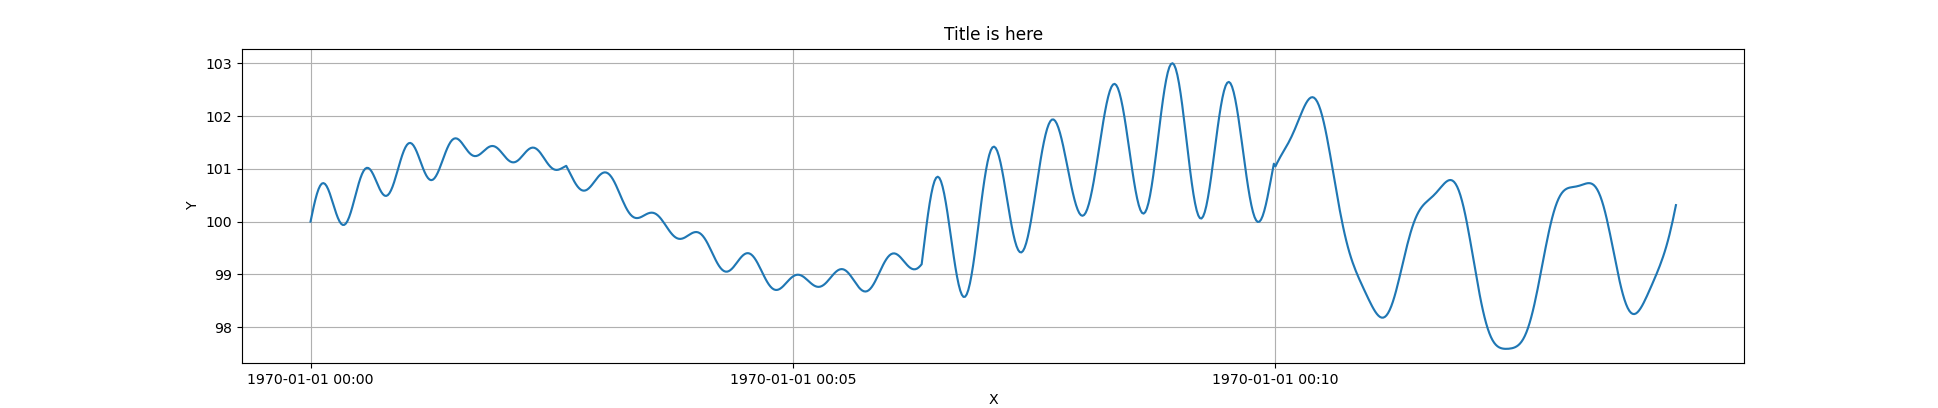

(850, 2)


In [6]:
# train dataset
areas = np.concatenate([
    np.sin(np.linspace(0, 6*2*np.pi, 160))*0.3 ,
    np.sin(np.linspace(0, 3*2*np.pi, 220))*0.03,
    np.sin(np.linspace(0, 6*2*np.pi, 220))*1.2,
    np.sin(np.linspace(0, 3*2*np.pi, 250))*1.6,
])
trend_1 = np.sin(np.linspace(0, 2*2*np.pi, len(areas))) * 1.3
trend_2 = np.linspace(0, 4, len(areas)) * 0.1
noise_1 = np.sin(np.linspace(0, 121, len(areas)))*0.1
noise_2 = np.sin(np.linspace(0, 181, len(areas)))*0.2

dataset = trend_1 + trend_2 + noise_1 + noise_2 + areas

dataset = dataset + 100

raw_data = np.concatenate([dataset.reshape(-1,1), dataset.reshape(-1,1)], axis=1)
data_train = pd.DataFrame(raw_data, columns=["lowest_ask", "highest_bid"], dtype=np.float32)
plot_and_go(data_train, fig_x=19, fig_y=4, dpi=51)

<IPython.core.display.Javascript object>


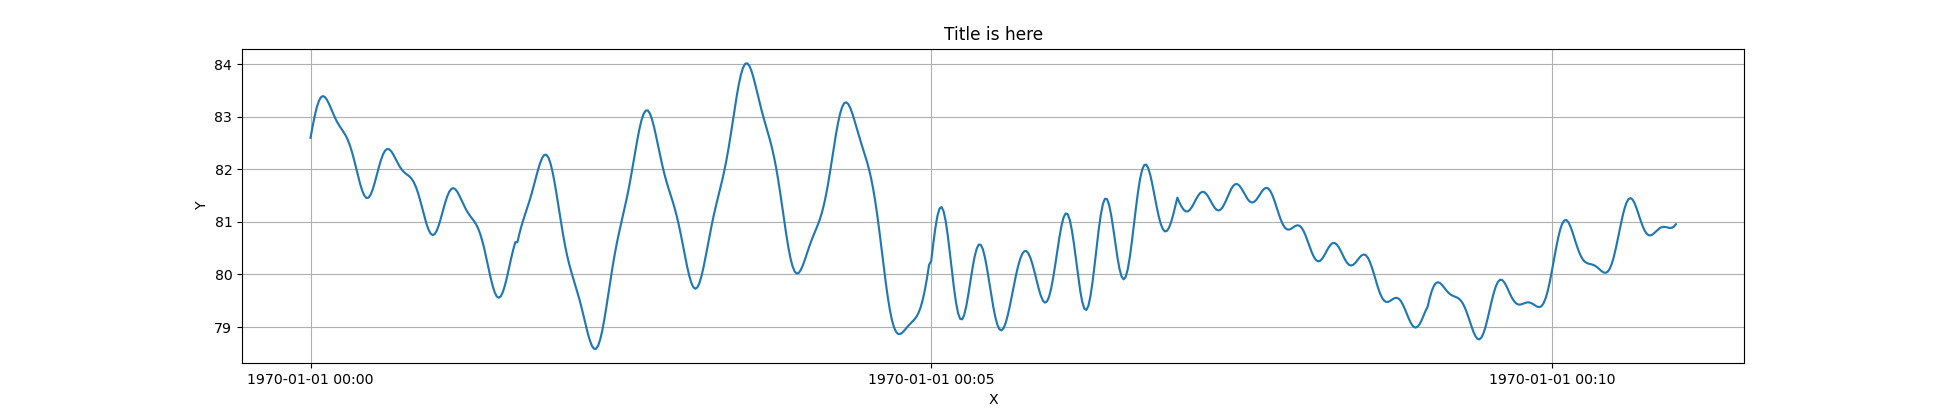

(661, 2)


In [7]:
# test dataset

areas = [
    np.sin(np.linspace(0, 3*2*np.pi, 100))*0.6,
    np.sin(np.linspace(0, 4*2*np.pi, 200))*1.6,
    np.sin(np.linspace(0, 6*2*np.pi, 120))*0.8,
    np.sin(np.linspace(0, 3*2*np.pi, 120))*0.05 ,
    np.sin(np.linspace(0, 4*2*np.pi, 121))*0.5,
    
]
areas = np.concatenate(areas)
trend_1 = np.cos(np.linspace(0, 3*2*np.pi, len(areas))) * 1.
trend_2 = np.linspace(4, 0, len(areas)) * 0.4
noise_1 = np.sin(np.linspace(0, 84, len(areas)))*0.2
noise_2 = np.sin(np.linspace(0, 262, len(areas)))*0.2

dataset = trend_1 + trend_2 + noise_1 + noise_2 + areas

dataset = dataset + 80

raw_data = np.concatenate([dataset.reshape(-1,1), dataset.reshape(-1,1)], axis=1)
data_test = pd.DataFrame(raw_data, columns=["lowest_ask", "highest_bid"], dtype=np.float32)
plot_and_go(data_test, fig_x=19, fig_y=4, dpi=51)

# Инициализация компонентов

## Core

In [8]:
core_config = {
    "action_controller":{"class": "BasicTrainController", "params":{ 
            "penalty": -1, 
            "market_fee": 0.0015,
            "wait_scale": 15, 
            "open_scale": 0, 
            "hold_scale": 15, 
            "close_scale": 7, 
            "last_points_mean": 1
        },},


    "observation_builder":{
        "class": "ObservationBuilder",
        "inputs": [
            {"class": "Input1D", "features": [{"class": "RawContextFeature", "params": {"name":"is_open"}}]},
            {"class": "Input2D", "features": [
                {"class": "RatesFeature", "params": {"step_factor":1, "scale_output": 30}},
                #{"class": "RatesFeature", "params": {"step_factor":3, "scale_output": 40}},
                {"class": "ProfitFeature", "params": {"step_factor":1, "scale_output": 0.5, "normalization":True, "clip_output":2}}
            
            ]}
        ]
    }
}
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
core_constructor = Constructor()
env_core = core_constructor.get_core(ALIAS, core_config)

## Datapoint factory

In [10]:
# Параметры точки наблюдения
observation_len = 20
offset = get_max_step_factor(core_config) * observation_len + 1

dp_factory_config = {
    "observation_len": observation_len,                            # Количество точек наблюдения в сэмпле
    "offset": offset,                                 # Хвост исторических данных
    "future_points": 0,                               # Количество будущех точек для предсказания тренда (временное решение)
    "step_size": 1                                    # Шаг по датасет
 }

dpf_train = DataPointFactory(dataset=data_train, **dp_factory_config, alias='train')
dpf_test = DataPointFactory(dataset=data_test, **dp_factory_config, alias='test')

<IPython.core.display.Javascript object>


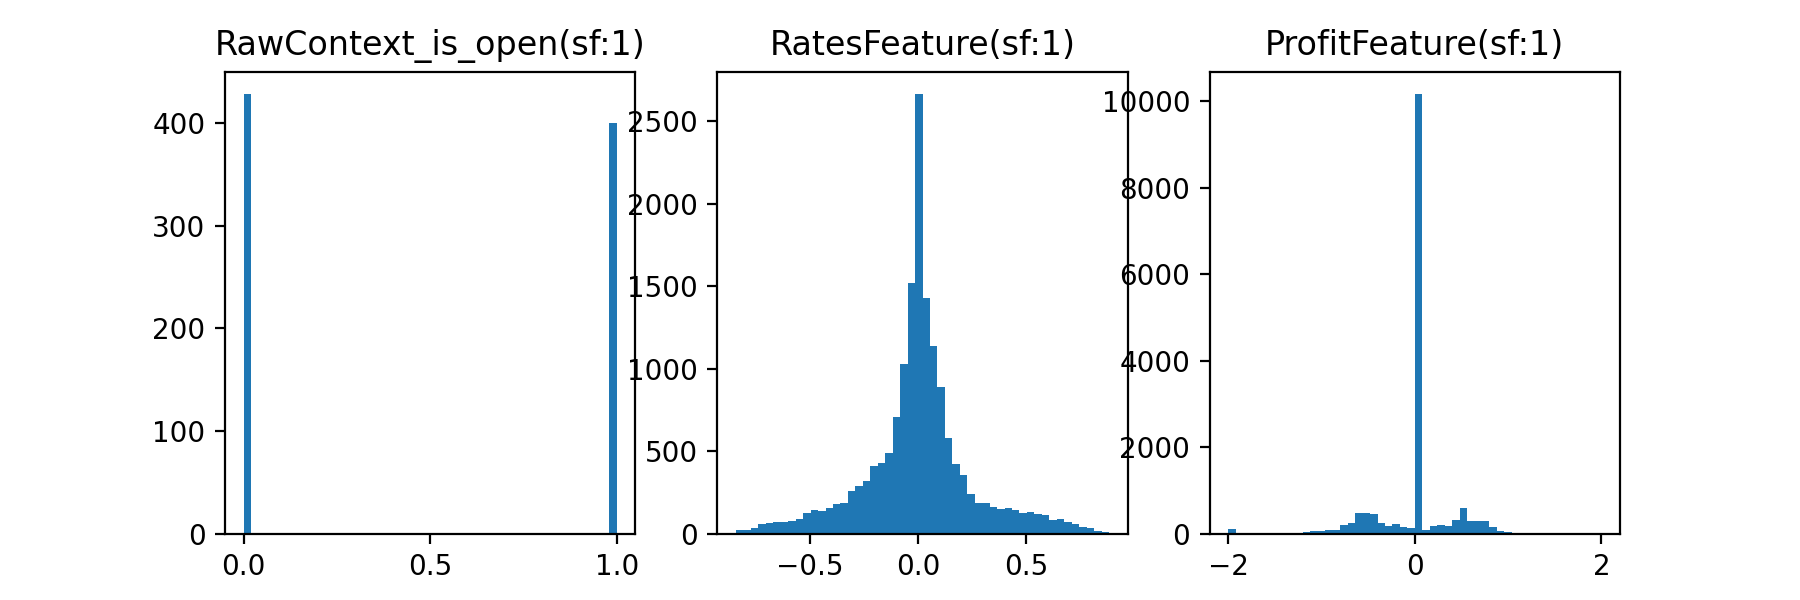

In [11]:
data = distribution_analysis(dpf_train, env_core, trade_every=50, plot_x_size=3, plot_y_size=3)

# Нейронная сеть

In [12]:
ACTIVATION = 'relu'
env = TradeEnv(env_core, dpf_train, alias=ALIAS, log=False, log_obs=False)
def create_q_model(env):
    num_actions = env.action_space
    #----------------------------------------------
    
    inp_static = Input(shape=env.observation_space[0])
    
    inp_timesteps = Input(shape=env.observation_space[1])
    conv_ts = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', input_shape=env.observation_space[1], activation=ACTIVATION)(inp_timesteps)
    conv_ts = MaxPool1D(pool_size=3)(conv_ts)
    conv_ts = Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation=ACTIVATION)(conv_ts)    
    conv_ts = MaxPool1D(pool_size=2)(conv_ts)
    flt_ts = Flatten()(conv_ts)
    flt_ts = BatchNormalization()(flt_ts)
    
    concat = Concatenate()([inp_static, flt_ts])
    
    
    #reshaped = Reshape((1,-1))(concat)
    #lstm1 = LSTM(256, activation=ACTIVATION, return_sequences=True, input_shape=())(reshaped)
    #lstm1 = LSTM(64, activation=ACTIVATION, return_sequences=False, input_shape=())(lstm1)
   
    
    classif = Dense(512, activation=ACTIVATION)(concat)
    classif = Dropout(0.3)(classif)
    classif = Dense(384, activation=ACTIVATION)(classif)
    classif = Dropout(0.3)(classif)
    classif = Dense(256, activation=ACTIVATION)(classif)
    classif = Dropout(0.3)(classif)

    output = Dense(num_actions, activation='softmax')(classif)

    model = Model(inputs=[inp_static, inp_timesteps], outputs=output)
    return model
model = create_q_model(env)
model_target = create_q_model(env)

print(model.summary())

2023-09-23 18:59:33.813263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20, 2)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 20, 32)       352         ['input_2[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 6, 32)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 6, 64)        6208        ['max_pooling1d[0][0]']          
                                                                                              

# Обучение

In [14]:
random.seed(seed_value)

core_train = core_constructor.get_core("train", core_config)
env = TradeEnv(core_train, dpf_train, alias=ALIAS, log=False, log_obs=False)

model = create_q_model(env)
model_target = create_q_model(env)
agent = DQNAgent(env, model, model_target)

agent.epsilon_random_frames = 1200   #(5% = 650)
agent.epsilon_greedy_frames = 25000 #(100% = 25000)
agent.max_memory_length     = 25000  #(20% = 2600)
agent.max_steps_per_episode = 50000
agent.gamma = 0.97
agent.epsilon_min = 0.01
agent.batch_size = 32
agent.update_after_actions = 4
agent.update_target_network = 1500   #(1% = 130)
agent.loss_function = tf.keras.losses.Huber() # #tf.keras.losses.Huber() #tf.keras.losses.MeanSquaredError()
agent.optimizer = Adam(learning_rate=0.0001, clipnorm=0.001)    #Adam(learning_rate=learning_rate) RMSprop(learning_rate=learning_rate) SGD(learning_rate=learning_rate)


tp = TrainPlot4()
core_test = core_constructor.get_core("test", core_config)
tm = TrainManager(agent, core_test, dpf_test, tp, alias=ALIAS)

Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


In [13]:
tm.load_snapshot(250000)

Снепшот успешно загружен на эпизоде 306


In [15]:
tp.init_plot(width=1000, height=800)
tp.update_plot(tm.history)

FigureWidget({
    'data': [{'legendgroup': '1',
              'line': {'color': '#109618', 'width': 1},
              'mode': 'lines',
              'name': 'Train',
              'type': 'scatter',
              'uid': '5037f1a5-8792-425e-bf3b-acda18f5dfdf',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'legendgroup': '1',
              'line': {'color': '#FF9900', 'width': 1},
              'mode': 'lines',
              'name': 'Test',
              'type': 'scatter',
              'uid': '22f7dd98-7053-42c6-a627-ccb394c6ec70',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'legendgroup': '2',
              'line': {'color': '#D62728', 'width': 1},
              'mode': 'lines',
              'name': 'Train',
              'type': 'scatter',
              'uid': '910b775e-7c78-4fc8-b3f4-02e9ab695088',
              'xaxis': 'x2',
              'yaxis': 'y3'},
             {'legendgroup': '2',
              'line': {'color': '#FF9900'

1. Тест разных конфигов CNN с размерами фильтров 3-3, 3-5, 5-5 - лучше всего работает 5-3.
2. Тест scale_close 12-9-7-5 - оптимально оказалось со значением 7!  Мменьше торгует и ощутимо больше зарабатывает!
3. Тест gamma - призначениях 0.95-0.96 склонен к большей нестабильности результатов и цифры в среднем получаются хуже. На 0.98-0.99 стабильность выше, однако максимальные значения не самые высокие (хуже 0.97). С BadAction ситуация неодглзначная - где-то отсутствуют (0.97), где-то есть эпизодические всплески поменьше(0.95/0.96) или побольше (0.98), где-то появляется тренд к росту(0.99);
4. Тест UTN 1000/1500/3000 - 1000 и 1500 показали хорошие результаты, возможно 1500 не оптимальный выбор (надо более точно исследовать), а на 3000 максимальные цифры упали.

-- Итог -- 
- ActionControllerDiffReward | scale_wait=15, scale_open=0, scale_hold=15, scale_close=7
- obs_num=30
- CNN(32/5)-MaxPool(3)-CNN(64/3)-MaxPool(2)-Flatten-BN-Dense(512)-DO(0.3)-Dense(384)-DO(0.3)-Dense(256)-DO(0.3)
- gamma = 0.97, utn=1500, greedy_frames = 25000, history_len=25000, loss_function=Huber, Adam(learning_rate=0.0001)

Тесты по нейронной сети
 - Слабый классификатор 256-256 - ведет себя так же как и базовый вариант (512-384-256), но общие результаты чуть хуже (20%-22%)
 - Слабый классификатор 256-256 с более сложной CNN - меньше стабильности, хуже результаты (20%)
 - Жирный классификатор 2048-2048 - стабильнее базового варианта (512-384-256), нет уклона вниз по мере обучения(!), максимальный результат уть хуже - около 25%
 - padding=valid - очень нестабильно, макс результат как и с padding=same
 - глубокая CNN - 32/5-maxpool(2)-64/3-64/3-maxpool(2)-128/3-128/3 - принципиальных отличий нет, модет быть в начале чуть стабильнее, макс результат такой же. Тренд вниз тоже присутствует.
 - RNN - нестабильно!
 
Еще тесты нейронной сети
 - dropout почему-то не влияет на результаты. Одинаково с 0.3-0.5-0.7.
 - uaa=8,bs=64 - больше дисперсия результатов.
 - big.clissifier-1024-768-512 - принципиально рещультаты не иземнились. Был локальный провал, но скорее это вариативность.
 - big.clissifier-1024-1024 - нет тренда к падению, общий уровень 22-25%
 - big.clissifier-2048-2048 - нет тренда к падению, общий уровень 24-25%
 - big.clissifier-4096-4096 - нет тренда к падению, общий уровень 25-26%, в целом неплохо. Но очень долго обучается - здесь 18млн параметров. Сеть 1024-1024-1024 с 2.5 млн параметров работает лучше.
 - big.clissifier-1024-1024-1024 - есть уверенная полка с результатами около 28-30%, потом снижение. Но в целом очень достойно
 - big.clissifier-2048-2048-2048 - нет стабильности, расколбас от 20% до 25, местами до 29%. 

 
 
 
 
-- Итог --
Можно попробовать перейти на жирный классификатор - он не дает максимального результата (но близкий к нему),но кривая обучения более ровная и стабильная.




 

In [24]:
tm.go(max_frames=150000, test_every=2500, snapshot_every=50000, update_plot_every=2500, save_since=0.15)

20:03:46 Running reward: 2.85     at episode 123  | frame 100500 | eps: 0.01 | Running loss: 0.00248
20:04:16 Running reward: 2.83     at episode 125  | frame 102000 | eps: 0.01 | Running loss: 0.00250
20:04:52 Running reward: 2.70     at episode 127  | frame 103500 | eps: 0.01 | Running loss: 0.00253
20:05:24 Running reward: 2.75     at episode 129  | frame 105000 | eps: 0.01 | Running loss: 0.00253
20:05:58 Running reward: 2.88     at episode 130  | frame 106500 | eps: 0.01 | Running loss: 0.00254
20:06:36 Running reward: 3.02     at episode 132  | frame 108000 | eps: 0.01 | Running loss: 0.00256
20:07:08 Running reward: 3.24     at episode 134  | frame 109500 | eps: 0.01 | Running loss: 0.00257
20:07:42 Running reward: 3.38     at episode 136  | frame 111000 | eps: 0.01 | Running loss: 0.00259
20:08:12 Running reward: 3.32     at episode 138  | frame 112500 | eps: 0.01 | Running loss: 0.00263
20:08:46 Running reward: 3.35     at episode 139  | frame 114000 | eps: 0.01 | Running loss

# Test

In [25]:
tm.get_train_stat()

Profit: 24.74% | id: 87500 | Penalties: 3    | TotalReward: 8.95     Sparsity 0.43
Profit: 24.74% | id: 77500 | Penalties: 0    | TotalReward: 12.26    Sparsity 0.46
Profit: 24.35% | id: 100000 | Penalties: 11   | TotalReward: 1.01     Sparsity 0.40
Profit: 24.23% | id: 102500 | Penalties: 4    | TotalReward: 8.20     Sparsity 0.39
Profit: 24.21% | id: 107500 | Penalties: 0    | TotalReward: 11.78    Sparsity 0.48
Profit: 24.11% | id: 60000 | Penalties: 0    | TotalReward: 12.05    Sparsity 0.47
Profit: 24.08% | id: 85000 | Penalties: 0    | TotalReward: 11.71    Sparsity 0.40
Profit: 23.72% | id: 105000 | Penalties: 0    | TotalReward: 11.80    Sparsity 0.41
Profit: 23.69% | id: 110000 | Penalties: 1    | TotalReward: 10.91    Sparsity 0.43
Profit: 23.65% | id: 50000 | Penalties: 0    | TotalReward: 12.24    Sparsity 0.43
Profit: 23.58% | id: 90000 | Penalties: 4    | TotalReward: 8.09     Sparsity 0.48
Profit: 23.31% | id: 52500 | Penalties: 0    | TotalReward: 11.16    Sparsity 0.34

<IPython.core.display.Javascript object>


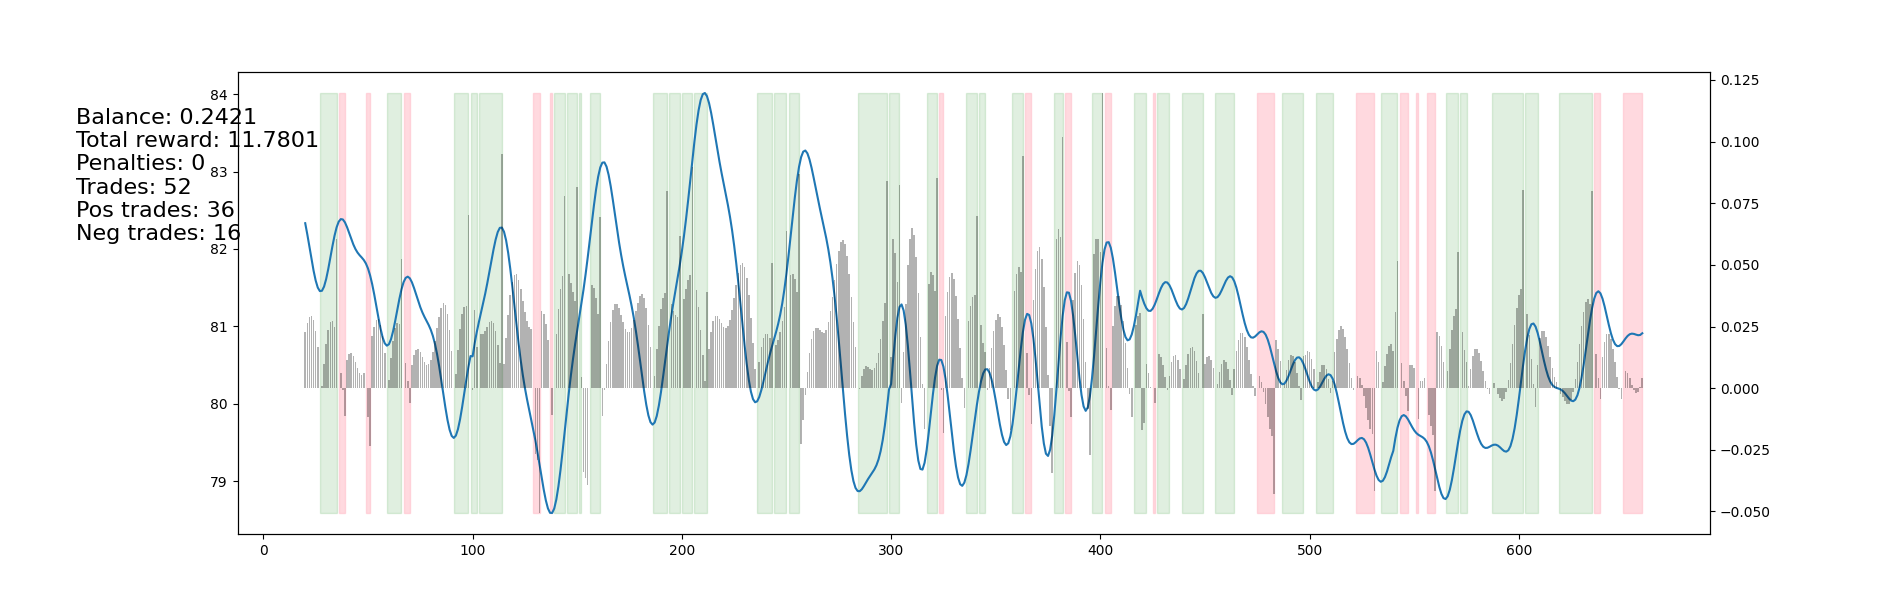

In [26]:
# max_id
model_id = 107500
model_test = tm.get_model(model_id)
#model_test = agent.model

player = Player(core_test, model_test, dpf_test)
result = player.play(fig_size_x = 19, fig_size_y = 6, dpi = 50, font_size = 16)

<IPython.core.display.Javascript object>


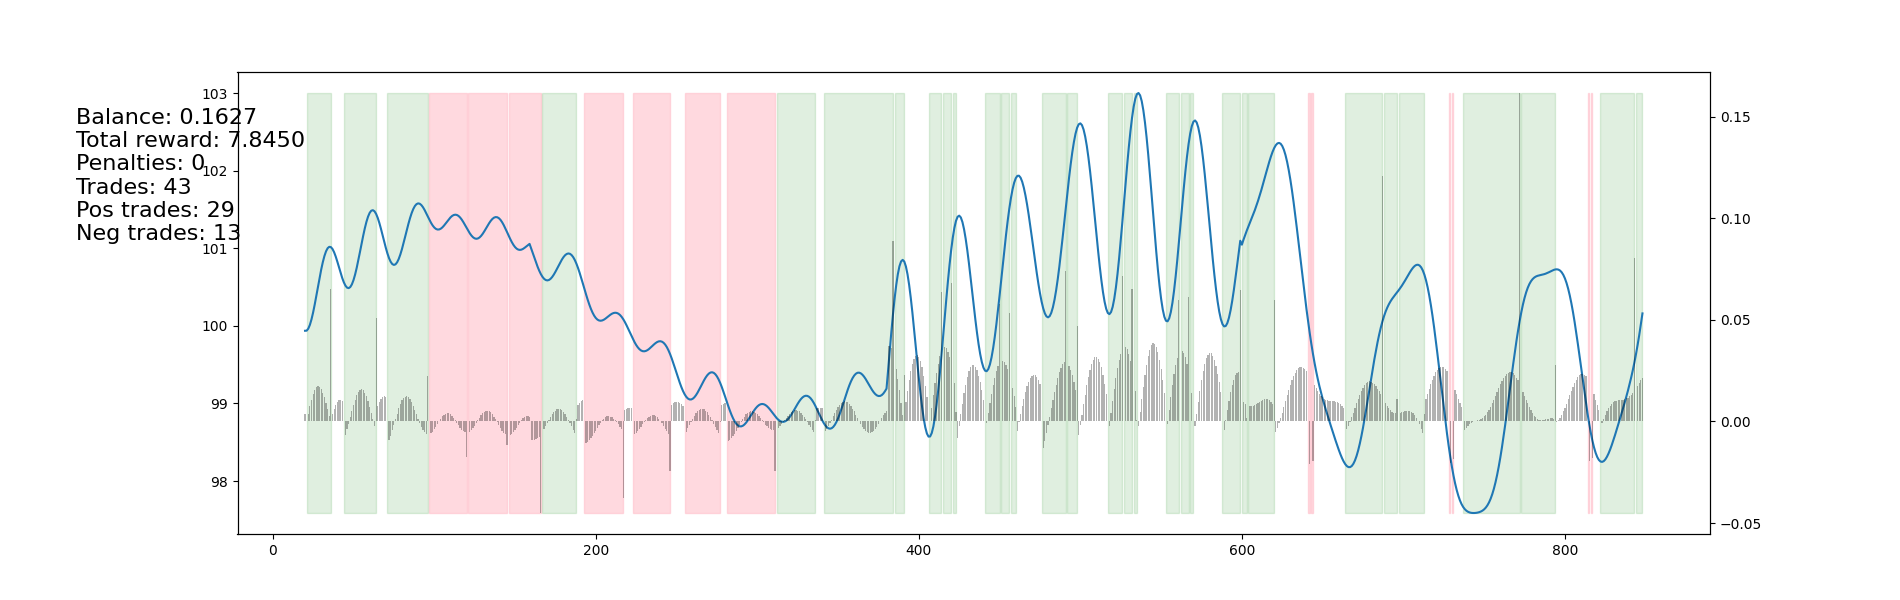

In [27]:
#model_id = 168000
#model_test = tm.get_model(model_id)
#model_test = agent.model

player = Player(core_test, model_test, dpf_train)
result = player.play(fig_size_x = 19, fig_size_y = 6, dpi = 50, font_size = 16)

## Итоги

Базовый конфиг - смог обучиться и получить лучший результат на тесте, но стабильности не было - встречались колебания (с этим надо бороться).

Конфиг:
 - Датасет: 30 наблюдений
 - Ядро
     - wait=10|open=0|hold=10|close=10
     - num_mean_obs=1, market_fee=0
 - Сеть: 
     - CNN(f96, k5, s1)-MaxPool(3)-CNN(f128, k3, s1)-MaxPool(2)
     - Flatten
     - Dense(512/do=0.3)-Dense(384/do=0.3)-Dense(256/do=0.3)
 - Агент:
     - greedy_frames=25k, random_frames=1000, memory_length=25000, eps_min=0.01
     - gamma = 0.975, batch_size = 32, uaa=4, utn=1000
     - loss=Huber, optimizer=Adam(learning_rate=0.0001, clipnorm=0.001)

Конфиг справился с задачей, но на тесте была просадка, потом выправился. 

----
1. Тест utn (1000) - выглядит так, что можно поставить utn побольше - на 1500 и 3000 нет локальной просадки, максимальные результаты такие же.
    - 250 и 500 - волны на тесте. тренировочный график, как ни странно - ровный.
    - 1500 и 3000 чуть стабильнее базового конфига (1000)
    
2. Тест learning_rate (0.0001) - текущее значение выглядит оптимальным.
    - 0.00005 - судя по графику, похоже, что обучался в 2х дольше, чем с базовым ЛР (0.0001)
    - 0.00025/0.0005/0.001 - результаты те же, но больше нестабильности.

3. Тест gamma(0.975) - текущее значение выглядит оптимальным (в сочетании с коэффициентами награды).
     - 0.95 - результаты нестабильны - то справляется отлично, то начинает частить и сильно не попадает в такт.
     - 0.99 - очень стабильно, но результаты не оптимальны, теряет 30-40% профита из-за частой торговли
----

4. Тест разных масштабов награды
    - пробовал 30х, 60х, 100х, 150х
    - Более высокие значения приводят к стабилизации обучения - нет провалов.
    - Часто торгует, максимальной награды не получить.
    - На 30х и 60х возрастает количество BadAction. (проблема!)
    - При увеличении penalty до -2 на 30х сократилось количество штрафов (но в ноль не ушло). Штраф -5 - (жду завершения обучения)
    
Надо увеличить штраф за неправильное действие

    